In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
warnings.filterwarnings('ignore')

# Data Exploration

## Loading

In [132]:
df = pd.read_csv('./data/Food_Service_Establishment_Inspection.csv')
print(len(df))
print(df.dtypes)
df.head()

/home/workstation/anaconda3/envs/datathon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1056115
FACILITY                           object
ADDRESS                            object
DATE OF INSPECTION                 object
VIOLATION ITEM                     object
VIOLATION DESCRIPTION              object
CRITICAL VIOLATION                 object
TOTAL # CRITICAL VIOLATIONS       float64
TOTAL #CRIT.  NOT CORRECTED       float64
TOTAL # NONCRITICAL VIOLATIONS    float64
LOCAL HEALTH DEPARTMENT            object
COUNTY                             object
FACILITY CODE                      object
FACILITY ADDRESS                   object
FACILITY CITY                      object
FACILITY POSTAL ZIPCODE            object
NYSDOH GAZETTEER (1980)             int64
FACILITY MUNICIPALITY              object
OPERATION NAME                     object
PERMIT EXPIRATION DATE             object
FOOD SERVICE TYPE                  object
FOOD SERVICE DESCRIPTION           object
PERMITTED  (D/B/A)                 object
PERMITTED  CORP. NAME              object
PERM. OPERATOR LAST NAME  

,FACILITY,ADDRESS,DATE OF INSPECTION,VIOLATION ITEM,VIOLATION DESCRIPTION,CRITICAL VIOLATION,TOTAL # CRITICAL VIOLATIONS,TOTAL #CRIT. NOT CORRECTED,TOTAL # NONCRITICAL VIOLATIONS,LOCAL HEALTH DEPARTMENT,...,PERMITTED (D/B/A),PERMITTED CORP. NAME,PERM. OPERATOR LAST NAME,PERM. OPERATOR FIRST NAME,NYS HEALTH OPERATION ID,INSPECTION TYPE,INSPECTION COMMENTS,FS FACILITY STATE,LATITUDE,LONGITUDE
0,LA COCINA AUTHENTIC MEXICAN RESTAURA,"211 WEST GENESEE STREET, CHITTENANGO",12/27/2011,15A,"Floors, walls, ceilings, not smooth, properly ...",Not Critical Violation,0.0,0.0,1.0,Madison County,...,NaN,LA COCINA AUTHENTIC MEXICAN RESTAURANT,MENDOZA,ANTONIO,751999,Inspection,15A-WALL BEHIND STEAM TABLE UNCLEAN(CORRECTED)...,NY,43.044641,-75.866773
1,KENSINGTON KOSHER DELI,"27A MIDDLE NECK ROAD, GREAT NECK",12/15/2009,15A,"Floors, walls, ceilings, not smooth, properly ...",Not Critical Violation,1.0,0.0,8.0,Nassau County,...,KENSINGTON KOSHER DELI,KENSINGTON KOSHER DELICATESSEN OF GREAT NECK INC,NaN,NaN,574775,Inspection,NaN,NY,40.787473,-73.728083
2,WILD FIG,"167 GLEN STREET, GLEN COVE",01/17/2013,15A,"Floors, walls, ceilings, not smooth, properly ...",Not Critical Violation,0.0,0.0,5.0,Nassau County,...,WILD FIG,KEBAB GRILL INC,NaN,NaN,574613,Inspection,NaN,NY,40.862681,-73.623665
3,APPLEBEE'S NEIGHBORHOOD GRILL & BAR,"938 S BROADWAY, HICKSVILLE",05/08/2013,15A,"Floors, walls, ceilings, not smooth, properly ...",Not Critical Violation,0.0,0.0,3.0,Nassau County,...,APPLEBEE'S NEIGHBORHOOD GRILL & BAR,APPLE FOOD SERVICE OF NY LLC,NaN,NaN,570570,Inspection,NaN,NY,40.746370,-73.500795
4,AMF WANTAGH LANES (SNACK),"1300 WANTAGH AVENUE, WANTAGH",11/27/2013,15A,"Floors, walls, ceilings, not smooth, properly ...",Not Critical Violation,0.0,0.0,5.0,Nassau County,...,AMF WANTAGH LANES,AMF BOWLING CENTERS INC,NaN,NaN,571471,Inspection,NaN,NY,40.690722,-73.508372


## Convert (from violations) to inspection summaries (only looking at critical violations)
(also add 'year' and 'month' column)

Focusing only on critical because:
* direct link to health, as deemed critical for proper restaurant operation -> intersting data
* specific analysis

In [133]:
grouped_inspection = df.groupby(by=['FACILITY', 'ADDRESS', 'COUNTY', 'DATE OF INSPECTION'])['TOTAL # CRITICAL VIOLATIONS'].agg({'n_crit_violations': 'sum'}).reset_index()
grouped_inspection['DATE OF INSPECTION'] = pd.to_datetime(grouped_inspection['DATE OF INSPECTION'])
grouped_inspection['YEAR'] = grouped_inspection['DATE OF INSPECTION'].apply(lambda x: x.year)
grouped_inspection['MONTH'] = grouped_inspection['DATE OF INSPECTION'].apply(lambda x: x.month)
print(len(grouped_inspection))
grouped_inspection.head()

/home/workstation/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


406616


,FACILITY,ADDRESS,COUNTY,DATE OF INSPECTION,n_crit_violations,YEAR,MONTH
0,BEJING HOUSE,"170 JERICHO TURNPIKE, SYOSSET",NASSAU,2018-01-16,33.0,2018,1
1,BEJING HOUSE,"170 JERICHO TURNPIKE, SYOSSET",NASSAU,2018-01-23,0.0,2018,1
2,BEJING HOUSE,"170 JERICHO TURNPIKE, SYOSSET",NASSAU,2016-04-14,4.0,2016,4
3,BEJING HOUSE,"170 JERICHO TURNPIKE, SYOSSET",NASSAU,2016-08-17,0.0,2016,8
4,BEJING HOUSE,"170 JERICHO TURNPIKE, SYOSSET",NASSAU,2015-11-17,5.0,2015,11


## Inpections grouped by restaurant and year

In [316]:
grouped_restaurant_year = grouped_inspection.groupby(by=['FACILITY', 'ADDRESS', 'COUNTY', 'YEAR', 'MONTH'])['n_crit_violations'].agg({'n_inspections': 'count',
                                                                                             'n_crit_violations': 'sum'}).reset_index()
grouped_restaurant_year['avg_violations_per_inspection'] = grouped_restaurant_year.n_crit_violations / grouped_restaurant_year.n_inspections
grouped_restaurant_year = grouped_restaurant_year.sort_values('avg_violations_per_inspection', ascending=False).reset_index()
grouped_restaurant_year.to_csv('grouped_restaurant_year.csv', index=False)
grouped_restaurant_year.head()

,index,FACILITY,ADDRESS,COUNTY,YEAR,MONTH,n_inspections,n_crit_violations,avg_violations_per_inspection
0,106319,Dominick's Restaurant,"1370 Burnet AVENUE, Syracuse",ONONDAGA,2007,8,1,450.0,450.0
1,253370,OTESAGA HOTEL,"60 LAKE STREET, COOPERSTOWN",OTSEGO,2015,9,1,430.0,430.0
2,34185,BOARDWALK RESTAURANT (THE),"1 LOWER AMHERST STREET, LAKE GEORGE",WARREN,2011,9,1,416.0,416.0
3,11084,ANGELA'S PIZZERIA & BREWERY,"4545 COUNTY ROUTE 32, PALENVILLE",GREENE,2015,6,1,391.0,391.0
4,276058,PUDGIE'S PIZZA,"224 ROBINSON STREET, BINGHAMTON",BROOME,2010,8,1,360.0,360.0


### Plotting the effect of number of inspections on the average violations found

Deicision to plot this data grouped by year, as in real life recent inspections have more effect on pressure to abide by rules/maintain hygene levels

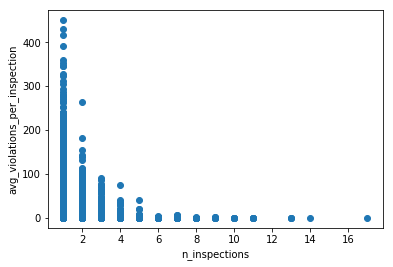

In [317]:
x = grouped_restaurant_year['n_inspections']
y = grouped_restaurant_year['avg_violations_per_inspection']

plt.xlabel('n_inspections')
plt.ylabel('avg_violations_per_inspection')

plt.scatter(x, y)
plt.show()


## Inspections grouped by county and year

In [136]:
d = {'n_crit_violations': ['sum'], 'n_inspections': ['sum', 'count']}
grouped_county_year = grouped_restaurant_year.groupby(by=['COUNTY', 'YEAR']).agg(d).reset_index()

grouped_county_year.columns = ['_'.join(col) for col in grouped_county_year.columns.values]
grouped_county_year = grouped_county_year.rename(columns={'n_crit_violations_sum': 'n_crit_violations', 'n_inspections_sum': 'n_inspections', 'n_inspections_count': 'n_restaurants'})

grouped_county_year['avg_inspection_per_restaurant'] = grouped_county_year.n_inspections / grouped_county_year.n_restaurants
grouped_county_year['avg_violations_per_inspection'] = grouped_county_year.n_crit_violations / grouped_county_year.n_inspections
grouped_county_year = grouped_county_year.sort_values('avg_violations_per_inspection', ascending=False).reset_index()
grouped_county_year.to_csv('grouped_county_year.csv', index=False)
grouped_county_year.head()

,index,COUNTY_,YEAR_,n_crit_violations,n_inspections,n_restaurants,avg_inspection_per_restaurant,avg_violations_per_inspection
0,685,WARREN,2010,3623.0,249,247,1.008097,14.550201
1,683,WARREN,2008,2672.0,190,189,1.005291,14.063158
2,259,HAMILTON,2012,1330.0,98,98,1.000000,13.571429
3,687,WARREN,2012,3535.0,267,262,1.019084,13.239700
4,686,WARREN,2011,3257.0,249,247,1.008097,13.080321


### Plotting trends per county over years

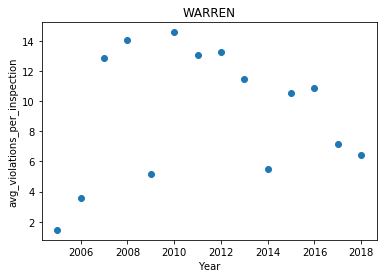

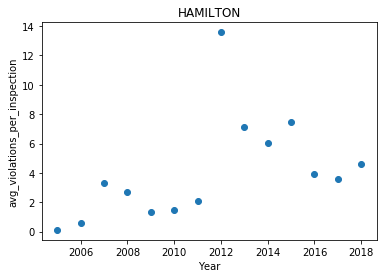

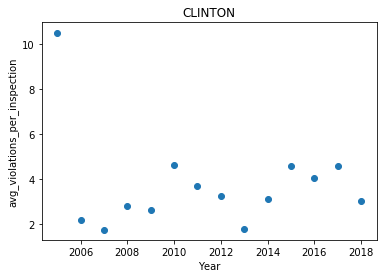

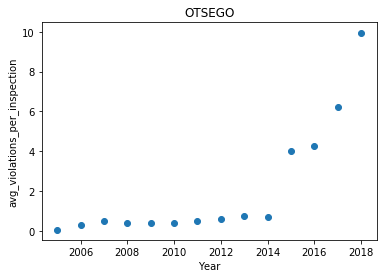

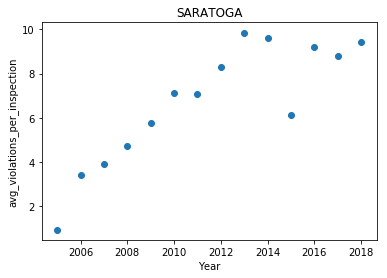

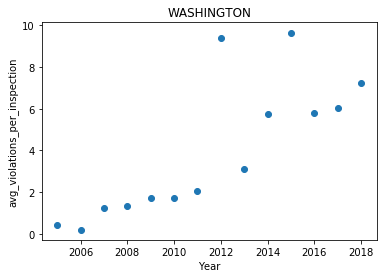

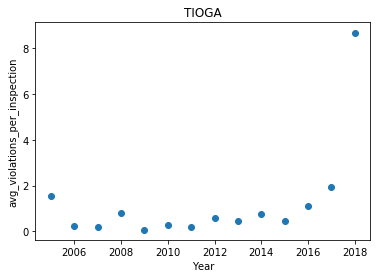

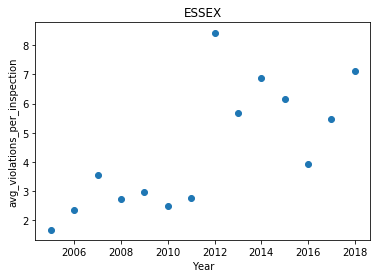

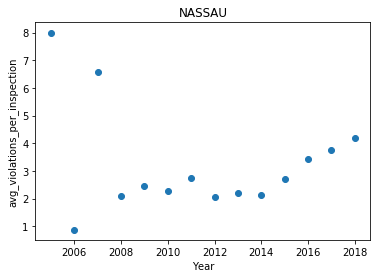

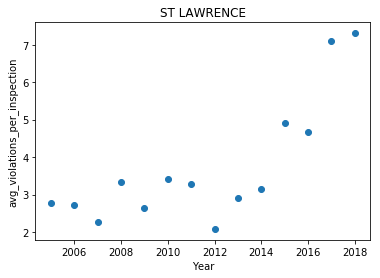

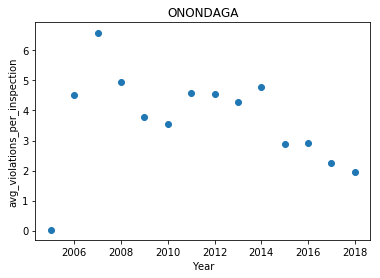

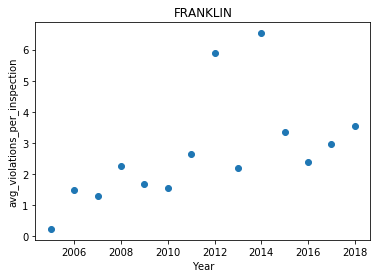

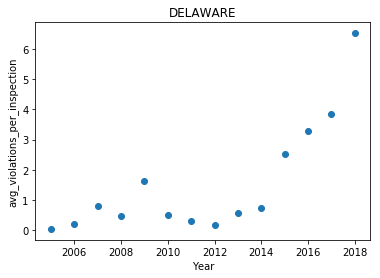

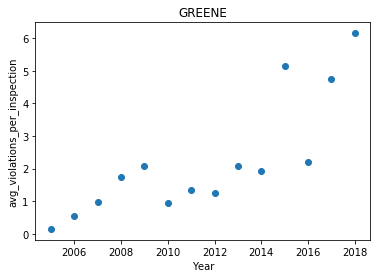

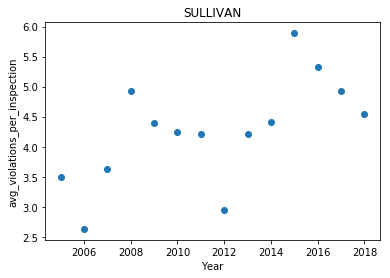

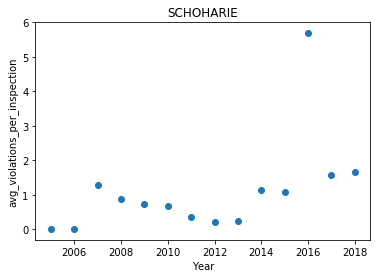

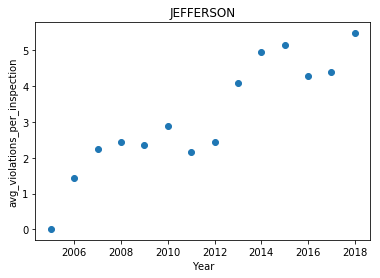

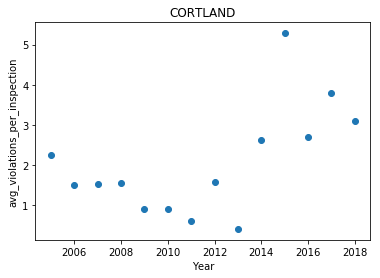

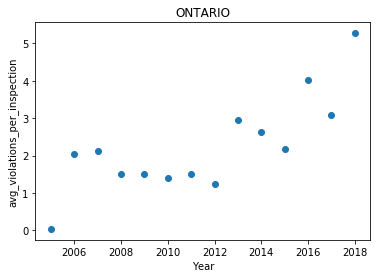

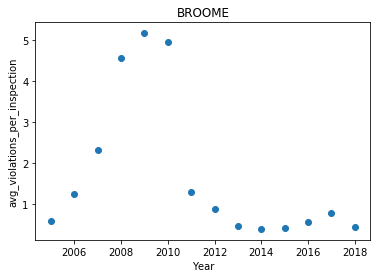

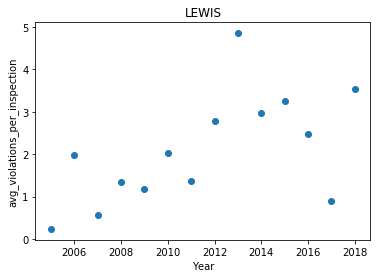

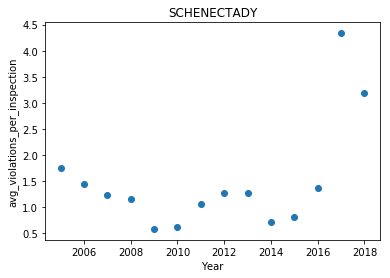

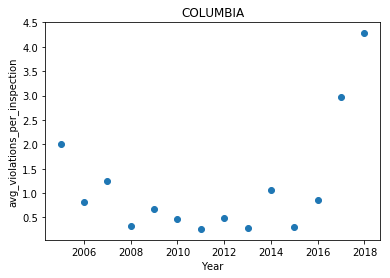

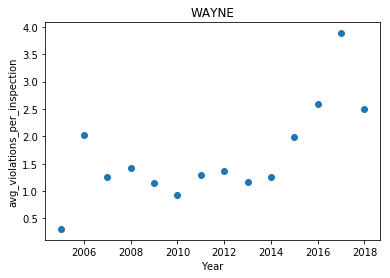

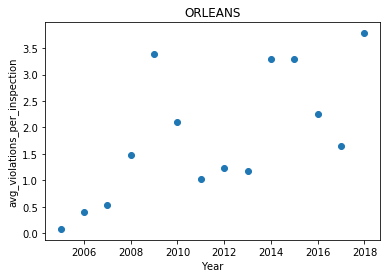

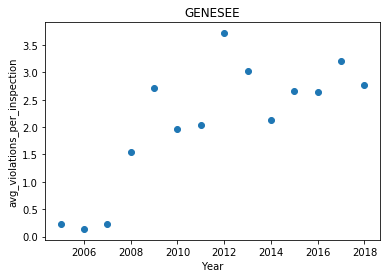

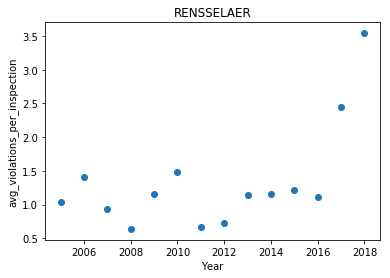

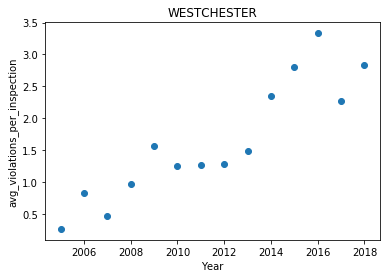

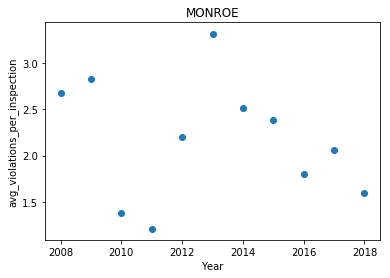

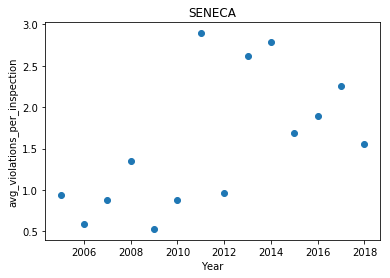

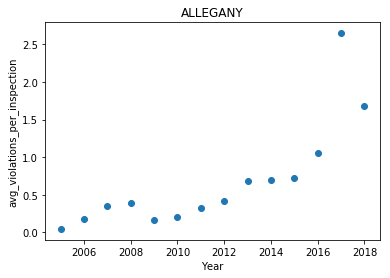

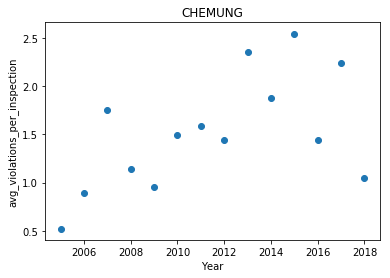

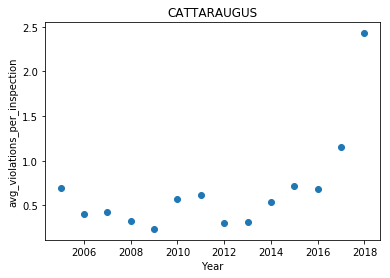

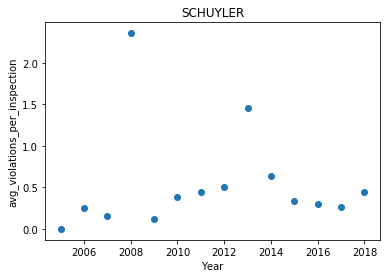

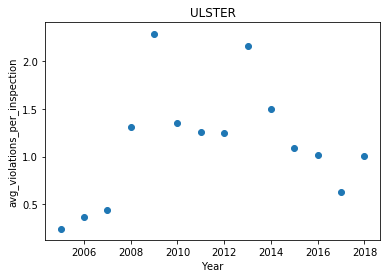

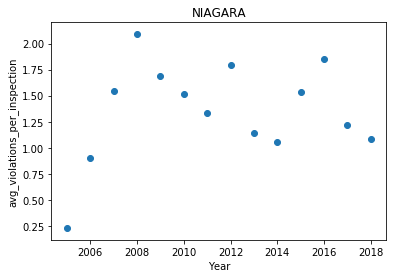

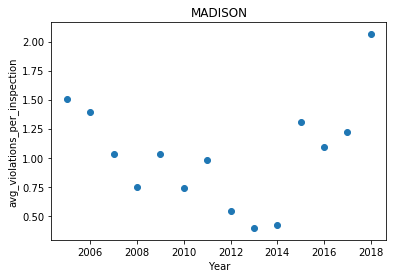

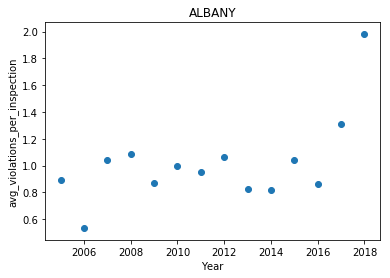

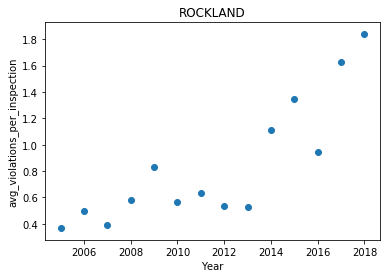

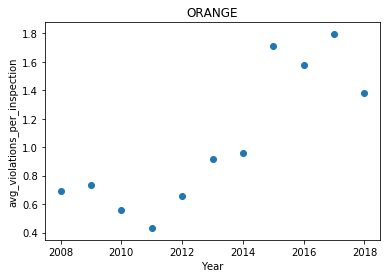

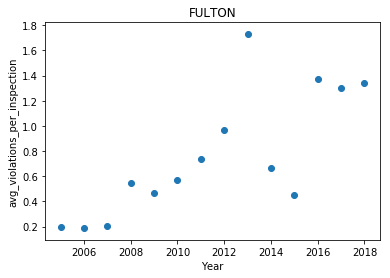

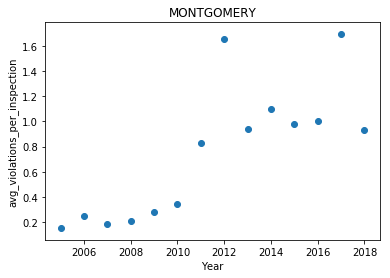

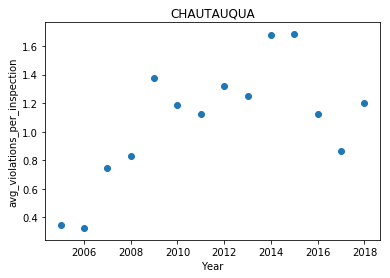

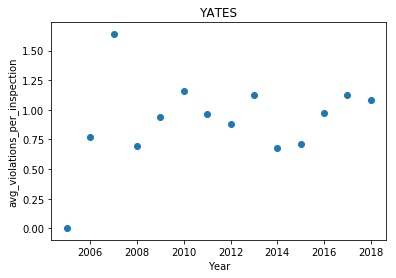

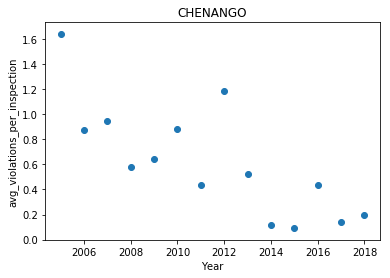

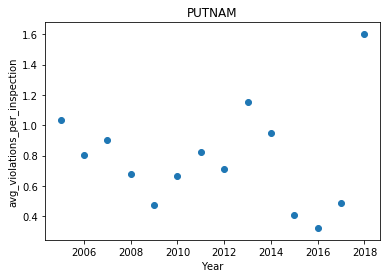

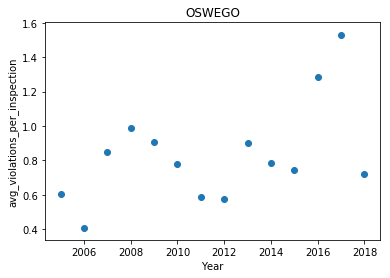

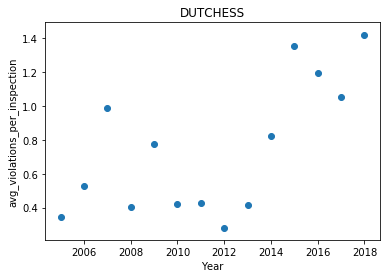

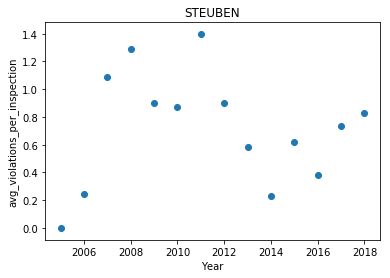

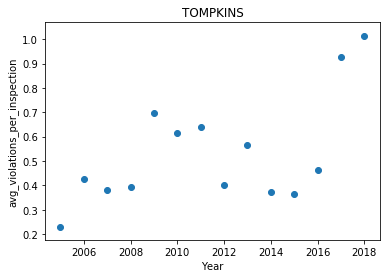

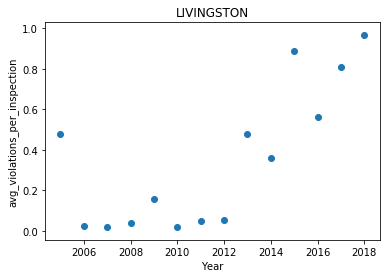

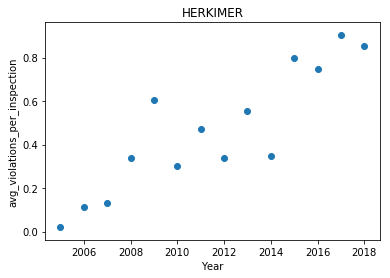

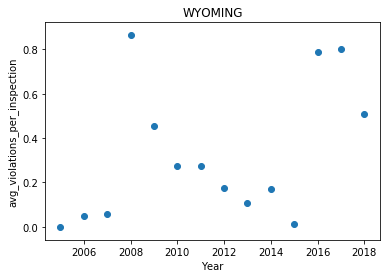

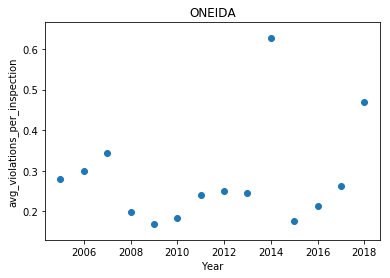

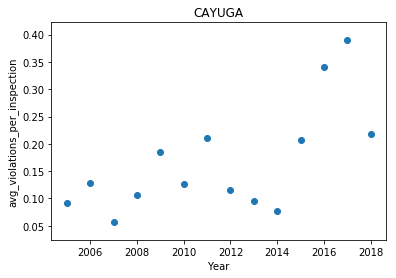

In [137]:

for county in grouped_county_year['COUNTY_'].unique():
  county_df = grouped_county_year[grouped_county_year['COUNTY_'] == county]
  plt.scatter(county_df['YEAR_'], county_df['avg_violations_per_inspection'])
  plt.title(county)
  plt.xlabel('Year')
  plt.ylabel('avg_violations_per_inspection')
  
  plt.show()

## Inspections all of NY grouped by year

In [315]:
grouped_ny_year = grouped_county_year.groupby(by=['YEAR_']).agg({'n_inspections': 'sum', 'n_crit_violations': 'sum', 'n_restaurants': 'sum'}).reset_index()
grouped_ny_year['avg_inspection_per_restaurant'] = grouped_ny_year.n_inspections / grouped_ny_year.n_restaurants
grouped_ny_year['avg_violations_per_inspection'] = grouped_ny_year.n_crit_violations / grouped_ny_year.n_inspections
grouped_ny_year.to_csv('grouped_ny_year.csv',index=False)
grouped_ny_year.head()

,YEAR_,n_inspections,n_crit_violations,n_restaurants,avg_inspection_per_restaurant,avg_violations_per_inspection
0,2005,3913,2767.0,3737,1.047097,0.707130
1,2006,16254,18064.0,15411,1.054701,1.111357
2,2007,17663,28881.0,16755,1.054193,1.635113
3,2008,21383,36859.0,20140,1.061718,1.723753
4,2009,25348,44973.0,23704,1.069355,1.774223


### Plotting overall trends NY over years

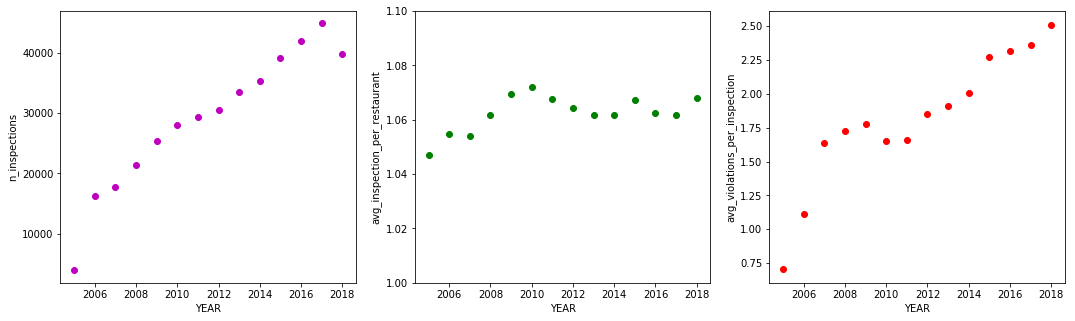

In [139]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(grouped_ny_year['YEAR_'], grouped_ny_year['n_inspections'], color='m')
axes[0].set_ylabel('n_inspections')
axes[0].set_xlabel('YEAR')

axes[1].scatter(grouped_ny_year['YEAR_'], grouped_ny_year['avg_inspection_per_restaurant'], color='g')
axes[1].set_ylabel('avg_inspection_per_restaurant')
axes[1].set_xlabel('YEAR')
axes[1].set_ylim([1, 1.1])

axes[2].scatter(grouped_ny_year['YEAR_'], grouped_ny_year['avg_violations_per_inspection'], color='r')
axes[2].set_ylabel('avg_violations_per_inspection')
axes[2].set_xlabel('YEAR')

plt.show()

## Inspections grouped by county

In [140]:
grouped_restaurant = grouped_inspection.groupby(by=['FACILITY', 'ADDRESS', 'COUNTY'])['n_crit_violations'].agg({'n_inspections': 'count',
                                                                                             'n_crit_violations': 'sum'}).reset_index()
grouped_restaurant.head()

/home/workstation/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,FACILITY,ADDRESS,COUNTY,n_inspections,n_crit_violations
0,BEJING HOUSE,"170 JERICHO TURNPIKE, SYOSSET",NASSAU,6,42.0
1,BELLMORE-MERRICK CSD SH CALHOUN HS,"1786 STATE STREET, NORTH MERRICK",NASSAU,9,0.0
2,J & T's PIZZA CORNER,"2702 MAIN STREET, YORK",LIVINGSTON,1,0.0
3,"""AIM"" 2 PLEASE","1A MICHAEL COURT, HUDSON",COLUMBIA,5,0.0
4,#1 CHINESE RESTAURANT,"228 WEST MAIN STREET, MALONE",FRANKLIN,25,588.0


# Model

## Feature Engineering

Further, we are interested in modeling the effect historical inspections as well as inspection frequency on the outcome of the latest inspection.

Specifically, we are interested in the outcome of the latest inspection solely as binary value: 'any critical violations' and 'no critical violations'. We want to test the influence of prior average violations per inspection (~> level of previous consideration of food safety guidelines), the previous average time between inspections (i.e. how often they get inspected), and the time between just the prior and the last inspection (~ negligence over time).

The binary value 'any/no critical violations' will be modeled as a Bernoulli distribution.
We find the effects of our features by doing a logistical regression.

We limit out training set to only restaurants, that have >= 6 inspections, as considering lower numbers of inspections do not give representative averages.

In [277]:
grouped_inspection_fe = grouped_inspection.copy()
grouped_inspection_fe['FACILITY_ADDRESS_KEY'] = grouped_inspection_fe.FACILITY + grouped_inspection_fe.ADDRESS
grouped_inspection_fe = grouped_inspection_fe.drop(['FACILITY', 'ADDRESS', 'YEAR', 'MONTH'], axis=1)
grouped_inspection_fe['unix_time'] = grouped_inspection_fe['DATE OF INSPECTION'].apply(lambda x: x.value//(1000000000*3600*24))
grouped_inspection_fe.head()


,COUNTY,DATE OF INSPECTION,n_crit_violations,FACILITY_ADDRESS_KEY,unix_time
0,NASSAU,2018-01-16,33.0,BEJING HOUSE 170 JERICH...,17547
1,NASSAU,2018-01-23,0.0,BEJING HOUSE 170 JERICH...,17554
2,NASSAU,2016-04-14,4.0,BEJING HOUSE 170 JERICH...,16905
3,NASSAU,2016-08-17,0.0,BEJING HOUSE 170 JERICH...,17030
4,NASSAU,2015-11-17,5.0,BEJING HOUSE 170 JERICH...,16756


Number of unique facilities: 35101
Numver of unique facilities with 3 or more inspections: 30446
Numver of unique facilities with 6 or more inspections: 25142


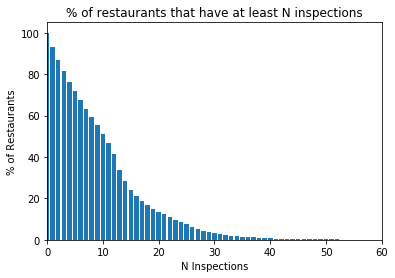

In [281]:
facilities = grouped_inspection_fe['FACILITY_ADDRESS_KEY'].unique()
print('Number of unique facilities:',len(facilities))
facility_count = grouped_inspection_fe.groupby(['FACILITY_ADDRESS_KEY'])['FACILITY_ADDRESS_KEY'].agg({'N': 'count'}).reset_index()
print('Numver of unique facilities with 3 or more inspections:',len(facility_count[facility_count['N'] > 2]))
print('Numver of unique facilities with 6 or more inspections:',len(facility_count[facility_count['N'] > 5]))

max_ = facility_count['N'].max()
y = [100*len(facility_count[facility_count['N'] > i])/len(facility_count) for i in np.arange(max_)]
x = np.arange(max_)
plt.bar(x, y)
plt.xlim([0, 60])
plt.title('% of restaurants that have at least N inspections')
plt.xlabel('N Inspections')
plt.ylabel('% of Restaurants')
plt.show()



In [279]:
grouped_inspection_fe.dtypes

COUNTY                          object
DATE OF INSPECTION      datetime64[ns]
n_crit_violations              float64
FACILITY_ADDRESS_KEY            object
unix_time                        int64
dtype: object

In [0]:
d = {'facility': [],
     'county': [],
    'avg_violations': [],
    'avg_time_between_inspections': [],
     'std_dev_time_between_inspections': [],
    'days_since_last_inspection': [],
    'n_violations_in_latest_inspection': []}

for i, facility in enumerate(facilities):
  facility_df = grouped_inspection_fe[grouped_inspection_fe['FACILITY_ADDRESS_KEY'] == facility].sort_values('DATE OF INSPECTION')
  if(len(facility_df) > 5 ):
    d['facility'].append(facility)
    d['county'].append(facility_df['COUNTY'].values[0])
    d['avg_violations'].append(facility_df['n_crit_violations'].mean())
    
    facility_dates = facility_df['unix_time'].values
    
    delta = []
    for j in range(1, len(facility_dates) - 1):
      delta.append(facility_dates[j] - facility_dates[j-1])
    d['avg_time_between_inspections'].append(np.mean(delta))
    d['std_dev_time_between_inspections'].append(np.std(delta))

    days_last_inspection = facility_dates[-1] - facility_dates[-2]
    d['days_since_last_inspection'].append(days_last_inspection)
    d['n_violations_in_latest_inspection'].append(facility_df['n_crit_violations'].iloc[-1])



  #if i == 100: break
  if i % 351 == 0: print(str(np.round(i/35101*100,2))+'%')


restaurant_stats = pd.DataFrame(d)

In [287]:
restaurant_stats.to_csv('restaurant_stats_6.csv', index=False)
print(len(restaurant_stats), 'rows')
print(restaurant_stats.dtypes)
restaurant_stats.head()

25142 rows
facility                              object
county                                object
avg_violations                       float64
avg_time_between_inspections         float64
std_dev_time_between_inspections     float64
days_since_last_inspection             int64
n_violations_in_latest_inspection    float64
dtype: object


,facility,county,avg_violations,avg_time_between_inspections,std_dev_time_between_inspections,days_since_last_inspection,n_violations_in_latest_inspection
0,BEJING HOUSE 170 JERICH...,NASSAU,7.000000,197.750000,190.180671,7,0.0
1,BELLMORE-MERRICK CSD SH CALHOUN HS1786 STATE...,NASSAU,0.000000,364.571429,98.857556,376,0.0
2,#1 CHINESE RESTAURANT 228 WEST M...,FRANKLIN,23.520000,196.304348,98.309376,228,54.0
3,"#1 King's Buffet, A115 Harte Haven Plaza, Mas...",ST LAWRENCE,16.807692,184.625000,105.664095,140,14.0
4,#121 RESTAURANT 2-4 DINGLE...,WESTCHESTER,1.561404,73.072727,84.821493,338,0.0


# Prediction

## Classification

In [435]:
restaurant_stats = pd.read_csv('restaurant_stats_6.csv')
restaurant_stats['any_violations_in_latest_inspection'] = restaurant_stats['n_violations_in_latest_inspection'].apply(lambda x: 1 if x > 0 else 0)
restaurant_stats.head()

,facility,county,avg_violations,avg_time_between_inspections,std_dev_time_between_inspections,days_since_last_inspection,n_violations_in_latest_inspection,any_violations_in_latest_inspection
0,BEJING HOUSE 170 JERICH...,NASSAU,7.000000,197.750000,190.180671,7,0.0,0
1,BELLMORE-MERRICK CSD SH CALHOUN HS1786 STATE...,NASSAU,0.000000,364.571429,98.857556,376,0.0,0
2,#1 CHINESE RESTAURANT 228 WEST M...,FRANKLIN,23.520000,196.304348,98.309376,228,54.0,1
3,"#1 King's Buffet, A115 Harte Haven Plaza, Mas...",ST LAWRENCE,16.807692,184.625000,105.664095,140,14.0,1
4,#121 RESTAURANT 2-4 DINGLE...,WESTCHESTER,1.561404,73.072727,84.821493,338,0.0,0


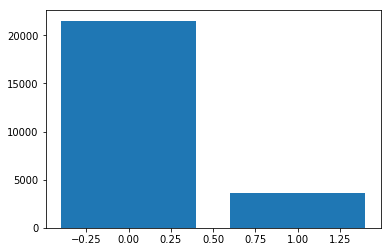

Number of positive classes:  3634
Number of negative classes:  21508


In [436]:
n_pos = len(restaurant_stats[restaurant_stats['any_violations_in_latest_inspection'] == 1])
n_neg = len(restaurant_stats[restaurant_stats['any_violations_in_latest_inspection'] == 0])

plt.bar(x=[0, 1], height=[n_neg, n_pos])
plt.show()

print('Number of positive classes: ', n_pos)
print('Number of negative classes: ', n_neg)

In [0]:
n_pos_class = len(restaurant_stats[restaurant_stats['any_violations_in_latest_inspection'] == 1])
pos_class = restaurant_stats[restaurant_stats['any_violations_in_latest_inspection'] == 1]
neg_class = restaurant_stats[restaurant_stats['any_violations_in_latest_inspection'] == 0].sample(n=n_pos_class)

downsampled_df = pd.concat([pos_class, neg_class]).reset_index(drop=True)

y = downsampled_df['any_violations_in_latest_inspection'] 
X = downsampled_df.drop(['county', 'facility', 'any_violations_in_latest_inspection', 'avg_time_between_inspections','std_dev_time_between_inspections', 'n_violations_in_latest_inspection'], axis=1)


In [438]:
k = 10
cv = StratifiedKFold(n_splits=k)

classification_cv_scores = []

for train, test in cv.split(X, y):
    scaler = RobustScaler()
    X_train, X_test = scaler.fit_transform(X.iloc[train, :]), scaler.transform(X.iloc[test, :])
    y_train, y_test = y.iloc[train], y.iloc[test]
    
    clf = LogisticRegression(penalty='l2', C=1.0)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    score = roc_auc_score(y_test, preds)
    classification_cv_scores.append(score)
    
print({'classification_cv_mean': np.mean(classification_cv_scores),
       'classification_cv_std_deviation': np.std(classification_cv_scores)})    

{'classification_cv_mean': 0.6772144522144521, 'classification_cv_std_deviation': 0.022313710563507748}


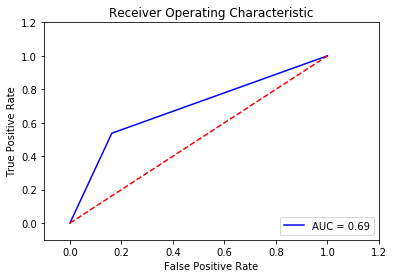

In [447]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [439]:
# Odds Ratio

log_reg = LogisticRegression(penalty='l2', C=1.0)

log_reg.fit(X, y)

feature_names = list(pd.DataFrame(X).head().columns.values)
odds_ratios = np.exp(log_reg.coef_)[0]

for i in range(len(feature_names)):
  print(str(feature_names[i]) + '\n' + str(odds_ratios[i])+ '\n')

avg_violations
1.303291941721663

days_since_last_inspection
1.0013496605547823

